In [1]:
#| default_exp activations

We're missing a way to identify how our models are training, 
to look inside them and see what's going on while they train.
Without that it's very hard to diagnose and fix problems.
When people lack a way of diagnosing problems inside their models 
they often randomly try things until something starts working...
We're going to do it properly.

# Activation stats

In [2]:
#|export
from __future__ import annotations
import random,math,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF

from miniai.datasets import *
from miniai.learner import *

We imported what we just created in the learner.  

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

We define a `set_seed` function with 3 random number generators: Pytorch's, Numpy's, and Python's, and seed all of them.
In Pytorch we can ask it to use a deterministic algorithm, so things should be reproducible.
We shouldn't always make things reproducible, but for lessons this is useful.
`set_seed(seed)` lets us set a reproducible seed.

In [4]:
#|export
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

### Dataset

Lets use the `fashion_mnist` data set, load it, and create a model similar to our previous models. (might be a bit bigger).

In [5]:
from datasets import load_dataset,load_dataset_builder
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
x,y = ds_builder.info.features
x, y

('image', 'label')

In [6]:
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

  0%|          | 0/2 [00:00<?, ?it/s]

## Baseline

In [7]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

Let's use `MulticlassAccuracy` and the same callbacks that we used before.<br>
We'll use the trainCB version (for no particular reason).

In [8]:
from torcheval.metrics import MulticlassAccuracy

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

We want to train quickly, i.e., training at a high LR.
The higher the LR the more we can find a more generalizable set of weights.
Training quickly also means looking at each data item less often, hence
fewer issues with overfitting.
If we can train at a high LR we're learning to train in a stable way.
Let's try a high LR of 0.6 and see what happens.

`fit()` function below creates the `Learner` with our callbacks, adding `xtra_cbs`.
We then `fit` it and return the Learner (in case we want to use it).

In [9]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

Below it is training and then it suddenly fells apart,
going well for a while, and then it stopped traning.
Now we have a graph to investigate.

accuracy,loss,epoch,train
0.211,2.215,0,train
0.154,2.867,0,eval


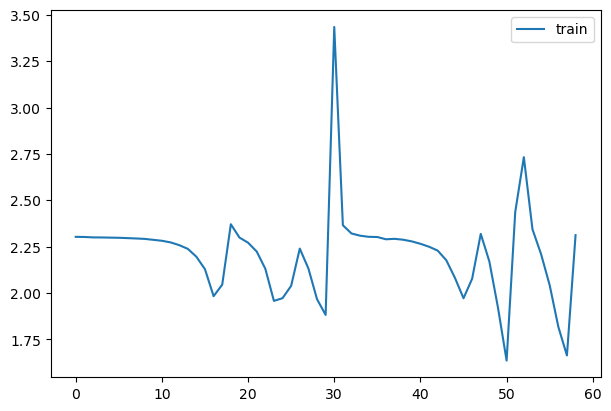

In [10]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

In above graph we see when it stops training well.
Why did it go badly? Was it because of our high LR? <br>
Let's try to look inside it to find out.

## Hooks

### Manual insertion
One way to look inside it would be to create our own sequential model.
We add at each layer the `mean()` and the standard deviation `std()` of that layer,
and append them to a couple of lists. <br>
We define `__iter__` which makes this into an iterator, 
so when we iterate through this model we can iterate through the layers.

In [15]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds [i].append(to_cpu(x).std ())
        return x
    
    def __iter__(self): return iter(self.layers)

We train this model as usual, and it produces an identical output and plots, because we are using the same seed as before.

accuracy,loss,epoch,train
0.228,2.129,0,train
0.356,1.821,0,eval


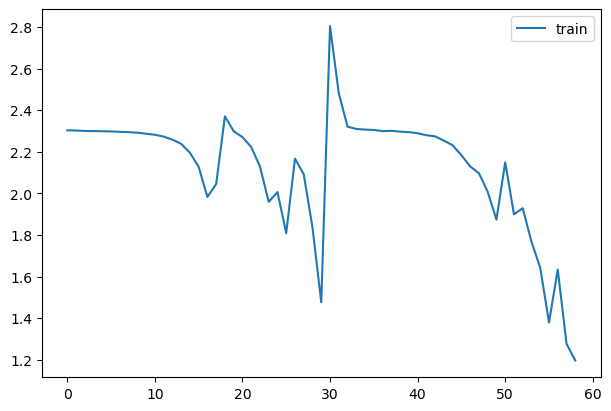

In [16]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

The difference is that we've now saved the means and standard deviations of each layer,
so now we can plot the activation means.
We've done it for every batch, so along the x-axis below we have batch number,
and on the y-axis we have the activation means.

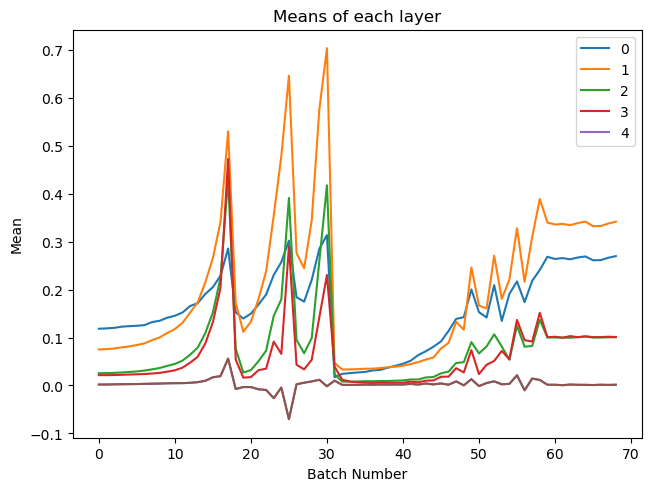

In [17]:
plt.title('Means of each layer')
plt.xlabel('Batch Number')
plt.ylabel('Mean')

for l in model.act_means: plt.plot(l)
plt.legend(range(5));

We have it for each layer: the 1st layer is the blue line, second is orange, etc.
The activations started pretty small close to zero, 
increased at an exponentially rate and then crashed, (before batch # 20)
increased again exponentially and crashed again, and again.

Each time they've gone up they go even higher and then they crashed.
When activations are close to 0, the inputs to each layer are numbers very close to 0.
Then the outputs are very close to 0 (we're doing just matrix multiplies).
When activations are very close to zero they're "dead units", not able to do anything.

0 mean is OK as long as they're **spread around zero.**
After batch 30 all of the activations are close to 0.

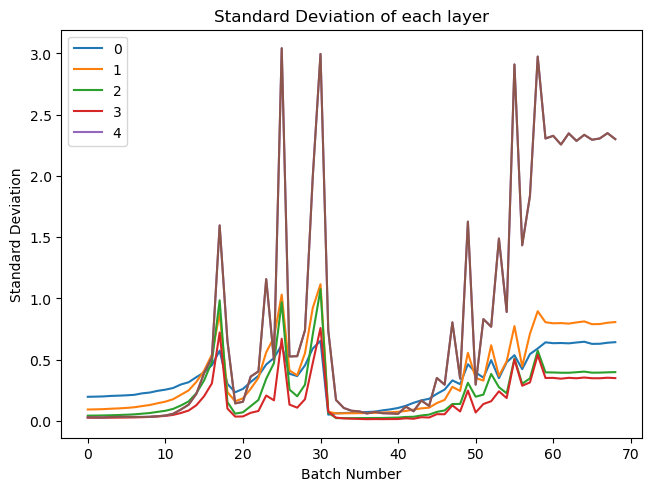

In [18]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));
plt.title('Standard Deviation of each layer')
plt.xlabel('Batch Number')
plt.ylabel('Standard Deviation');

The standard deviations tell an even stronger story.
We want the means of the activations to be about 0 and the standard deviations to be about 1.
0 mean is OK as long as they're spread around zero.
But a standard deviation close to 0 is terrible, because all of the activations are about the same.
After batch 30 all of the activations are close to 0, and all of the standard deviations are close to 0, so all the numbers are about the same, zero, so nothing is going on.

The same pattern is happening in the standard deviations. 
We start with not very much variety in the weights, it exponentially increases variety, 
and then it crashes again, exponentially increases, crashes again.
<mark> This is a classic shape of bad behavior.</mark>
and with these two plots we can really understand what's going on in the model.

After we train a model we may wonder if it is any good.
We look at this plot to see whether it's training nicely
(We'll see some nicer training pictures later).
If the mean is always about 0 and the variance always about 1,
there is a good chance we're training properly, else, we're certainly not.

### Pytorch hooks

Now lets do this in a more elegant way, because to look inside our models is critically important.
We don't have to do it manually, e.g., with our own sequential model, but we can use Pytorch hooks.
A **hook** is called when a registered layer is executed during the forward pass 
(forward hook) or the backward pass (backward hook).
Using hooks we don't have to rewrite the model, we can add them to any existing model.
So we can just use standard `nn.sequential` passing in our layers.

Hooks are PyTorch object we can add to any `nn.Module`. 

In [19]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

We're going to keep track of the activation means and standard deviation, 
so we create an empty list for means and stds for each layer in the model.

In [20]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

A hook is attached to a layer, and needs to have a function that takes 3 arguments: module, input, output. <br>
`append_stats` is going to be passed the layer number (`i`), the module (`mod`),
the input and the output.
We store the outputs mean in `act_means` and the output standard deviation in `act_std`.

In [21]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(to_cpu(outp).mean())
    act_stds [i].append(to_cpu(outp).std())

For each layer of the model we call `register_forward_hook`. 
The function that's going to be called is `append_stats` passing `i` as the first argument.
(via `partial`).

In [22]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

We now fit that model, it trains in the usual way, but after each layer it's
going to call the `append_stats` hook.

accuracy,loss,epoch,train
0.228,2.129,0,train
0.356,1.821,0,eval


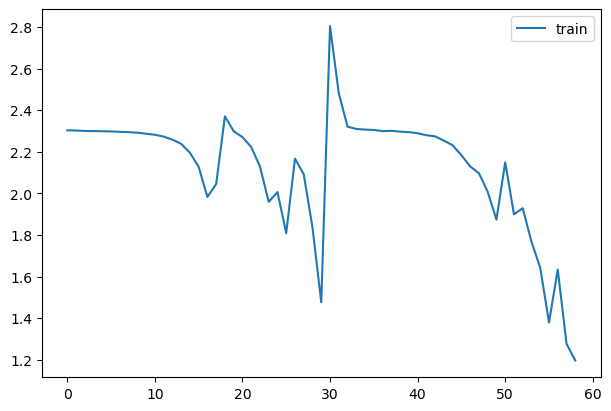

In [23]:
fit(model);

So we get the same thing as before.

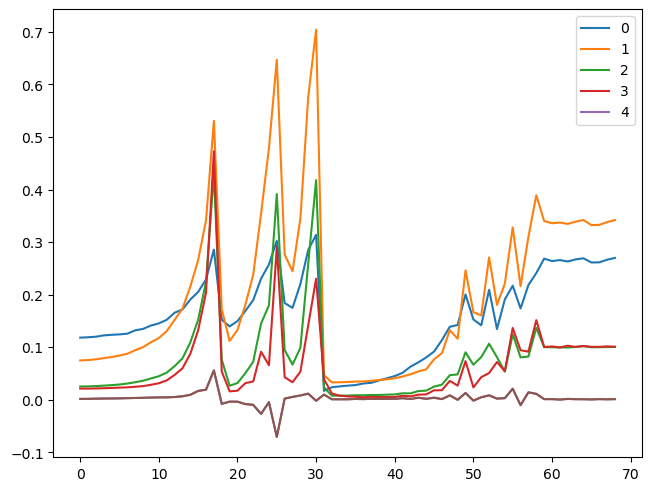

In [24]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

What's the difference between a hook and a callback? 
They are almost the same thing.  
Pytorch calls them hooks instead of callbacks.
Hooks are less flexible than the callbacks that we used in the Learner 
because we don't have access to all the available states, hence we can't change things.
Hooks are a particular kind of callback that is just setting a piece of code 
to be run when something happens, e.g., a layer in the forward or backward pass.
(We could describe the function that's being called back as the Callback, 
and the thing that's doing the Callback as the hook.)

### Hook class

We can refactor this in a Hook class. It's important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be released when the model is deleted.
When we create it we're going to pass in the module `m` that we're hooking so we call 
`m.register_forward_hook` and we pass the function that we want to be given (`f`).
To the `register_forward_hook` we also pass the `Hook` class.
We define a `remove()` to remove the hook. 
The `__del__` is called by Python when an object is freed, so when that happens 
we make sure that we remove this.

In [25]:
#|export
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

The new `append_stats` is going to get the hook (because that's what we asked to be passed).
If there's no `stats` attribute yet then let's create one, 
inside this object which is convenient.
Then we're going to be passed the `outp` activations so we put that on the CPU.
Then append the `.mean` and the `std`.

In [26]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [27]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [28]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

Now we can do the same thing as before but we don't have to set any of that `Global` stuff.
When we fit that it's going to run with the hooks.

accuracy,loss,epoch,train
0.228,2.129,0,train
0.356,1.821,0,eval


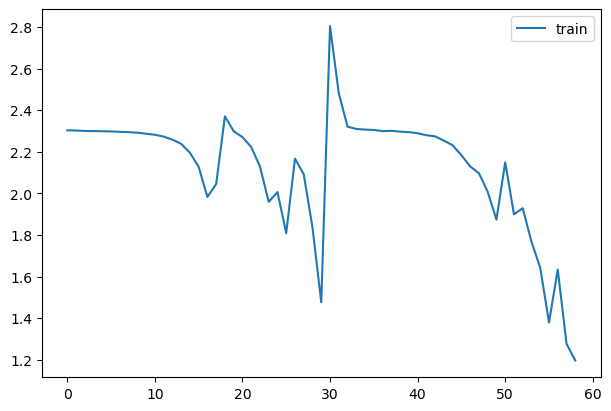

In [29]:
learn = fit(model)

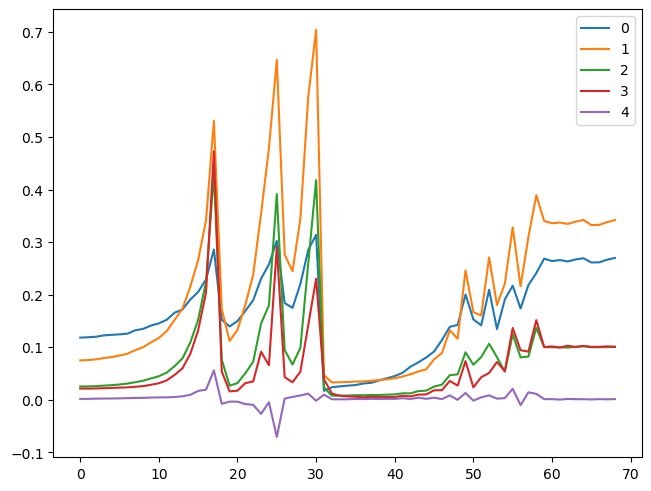

In [30]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));

We get the same shape and the same results.

### A Hooks class
As we're going to be adding multiple Hooks, and the list comprehension 
```Python
hooks = [Hook(l, append_stats) for l in model[:5].children()]
```
is a bit inconvenient, so let's create a hooks class.

#### Preliminaries

Below is a dummy context manager, `DummyCtxMgr`.
It's got `__enter__` which is going to return itself, and it's going to print something.
The second thing it's going to do is call the `dcm.hello()` code inside the context manager.
`dcm` is itself and so it's going to call `hello(self)` which prints "hello.".
Finally it's going to automatically call `__exit__`  which prints "all done!".

In [31]:
class DummyCtxMgr:
    def __enter__(self, *args):
        print("let's go!")
        return self
    def __exit__ (self, *args): print("all done!")
    def hello(self): print("hello.")

Below we call `with DummyCtxMgr()` and so it prints "let's go!" first, etc.

In [32]:
with DummyCtxMgr() as dcm: dcm.hello()

let's go!
hello.
all done!


#### what it's like to inherit from list. 
`DummyList(list)` is inheriting from list and we redefine how `__delitem__` works. 

In [33]:
class DummyList(list):
    def __delitem__(self, i):
        print(f"Say bye to item {i}")
        super().__delitem__(i)

We create a `Dummylist` as usual.

In [34]:
dml = DummyList([1,3,2])
dml

[1, 3, 2]

But if I delete an item from the list it's going to call our overridden version, and then it will call the original version. `super().__delitem__(i)`
So the list has now got removed that item and did this at the same time.

In [35]:
del(dml[2])
dml

Say bye to item 2


[1, 3]

### The Hooks class

We're going to use the most flexible way of creating context managers. 
The general way of creating a context manager  is to create a class 
and define two special things `__enter__` and `__exit__`.
The `Hooks` class inherits from `list`.
*(In Python, we can inherit from stuff like list).*
The `Hooks` object is a `list` and therefore we need to call the superclass Constructor.
And we're going to pass in that list comprehension,
that list of hooks where it's going to hook into each module (m in ms),
and the list of modules we ask to hook into.
`super().__init__([Hook(m, f) for m in ms])`
We're passing in a `nn.sequential` model, hence we can loop through it 
and it returns each of the layers.
`__exit__` is what's called automatically at the end of the whole block,
so when it is finished it's going through each hook (because it is a list) and removes it.
We also added an optional  `__delitem__` that lets us delete a single `Hook` from the list.

In [36]:
#|export
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [37]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

Now lets see how the `Hooks` class works, making it a context manager.
We're going to call, pass in the `model`, pass in the function to use `append_stats`, 
and then `fit(model)`. 
`__enter__` is called when it hits the with statement.
If we add an `as xxxx` after it then the contents of the `xxxx` variable 
will be whatever is returned from `__enter__`.
Here we just returned the object itself, so the the `Hooks` object is going to be stored in `hooks`.

Just one extra line of code  to set up the whole thing.
```Python
with Hooks(model, append_stats) as hooks:
    fit(model)
    ...
```
Then we can go through each hook and plot the `stats` (mean and standard deviation) of each layer. 

accuracy,loss,epoch,train
0.228,2.129,0,train
0.356,1.821,0,eval


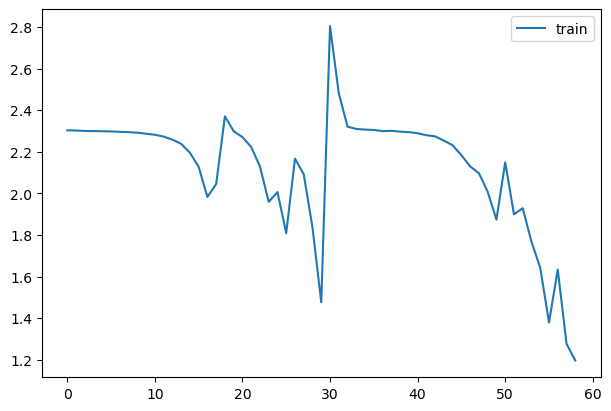

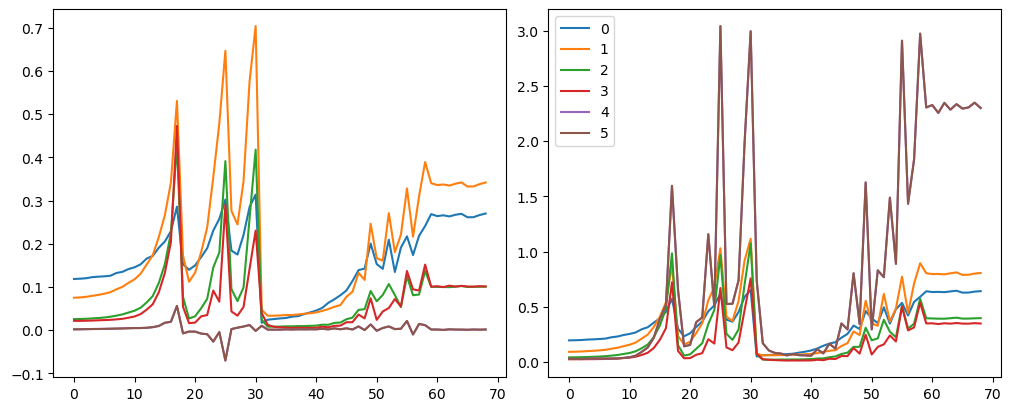

In [38]:
with Hooks(model, append_stats) as hooks:
    fit(model)
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        for i in 0,1: axs[i].plot(h.stats[i])
    plt.legend(range(6));

### HooksCallback

We had a `Hooks` class, and we simplify by putting hooks into a `Callback`,
`HooksCallback(Callback)`.
As usual we pass a function (`hookfunc`) that's going to be called for our hook.
We can optionally pass it a filter, `mod_filter`, as to what modules you want to hook.
In `before_fit` it will filter the modules in the learner:
```Python
mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
```

One thing that is convenient here is the `_hookfunc` function: 
```Python
if learn.training: self.hookfunc(*args, **kwargs)
```
Now we don't have to worry about checking whether in training or not.
It always checks whether we're in training 
and if so it calls that `hookfunc` function you passed in.
After it finishes it removes the hooks: `def after_fit(self): self.hooks.remove()`
We can iterate through the `hooks` and get the length of the `hooks` 
because it just passes these iterators and length down to self.hooks. 
```Python
def __iter__(self): return iter(self.hooks)
def __len__(self): return len(self.hooks)
```

In [57]:
#|export
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop):
        fc.store_attr()
        super().__init__()
    
    def before_fit(self, learn):
        mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if learn.training: self.hookfunc(*args, **kwargs)

    def after_fit(self, learn): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

Now we can create a hooks callback, `hc`, use the same `append_stats`
and then we can run the model.

In [58]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

In [59]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

We added `hc` as an extra callback `xtra_cbs` to `fit`. 
Now we've we can iterate through it and plot in the usual way.

accuracy,loss,epoch,train
0.228,2.129,0,train
0.356,1.821,0,eval


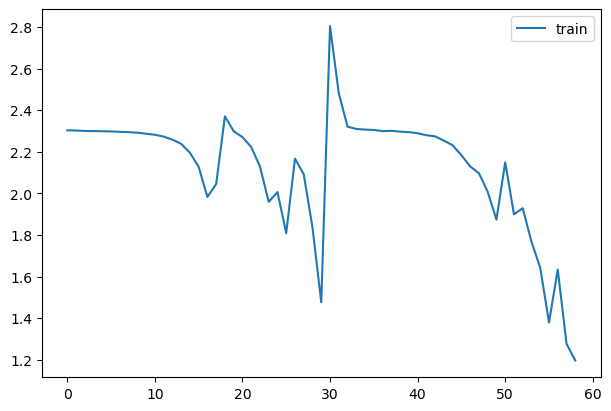

In [60]:
fit(model, xtra_cbs=[hc]);

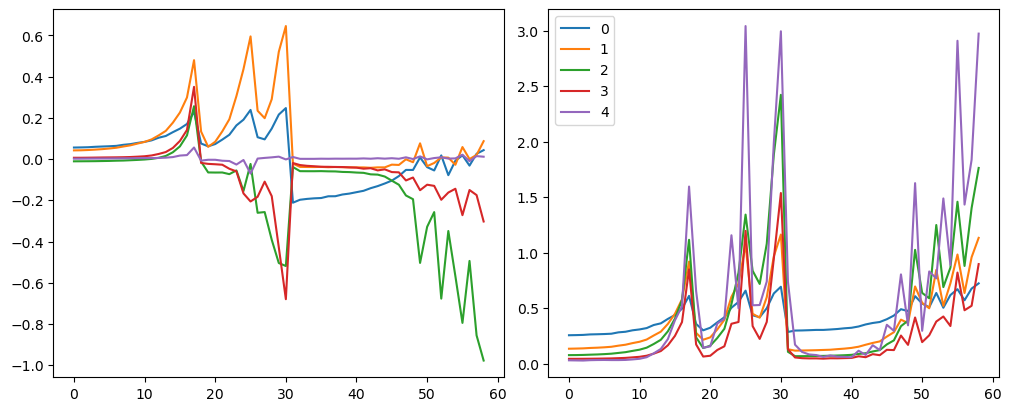

In [61]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1: axs[i].plot(h.stats[i])
plt.legend(range(6));

## Histograms - the *colorful dimension*

JH favorite single image explanations of what's going on inside a model:
the *colorful dimension*, which are histograms.
We're going to take our same `append_stats` (all the same as before) 
and add an extra line of code to get a histogram of the absolute values of the activations.
(a histogram takes a collection of numbers and tells how frequent each group of numbers are).
We're going to create 50 bins for our histogram.
We use our hooks that we just created and a new version of `append_stats`. 

In [62]:
#|export
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))

so it's going to train as before, but now in addition it will have in stats a histogram, `histc`.

accuracy,loss,epoch,train
0.228,2.129,0,train
0.356,1.821,0,eval


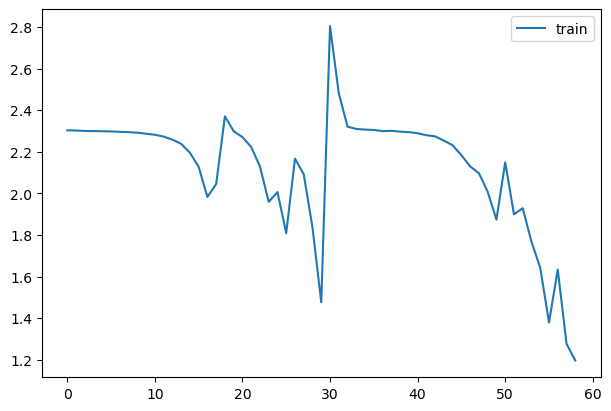

In [63]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
fit(model, xtra_cbs=[hc]);

In [64]:
#|export
# Thanks to @ste for initial version of histogram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

The plot below is showing is for the 1st, 2nd, 3rd, and 4th layers what does the training look like.
We're seeing this same pattern, but what is this pattern showing, what exactly is going on in these pictures?

We turn that histogram into a single column of pixels.
If I take one column of pixels, that's actually one histogram.
To do it is we take the numbers of the histogram, let's say it's like 14 2 7 9 11 3 2 4 2. 
We turn it into a single column, in this case we've got nine groups.
We create nine groups.
We take the first group (it's 14) and we color it with a gradient according to how big that number is.
14 is a big number, so we use red is really big.
Next (2) really small which might be green.
Then (7) in the middle blue, (9) is bigger red, (11) bigger more red, and so forth.


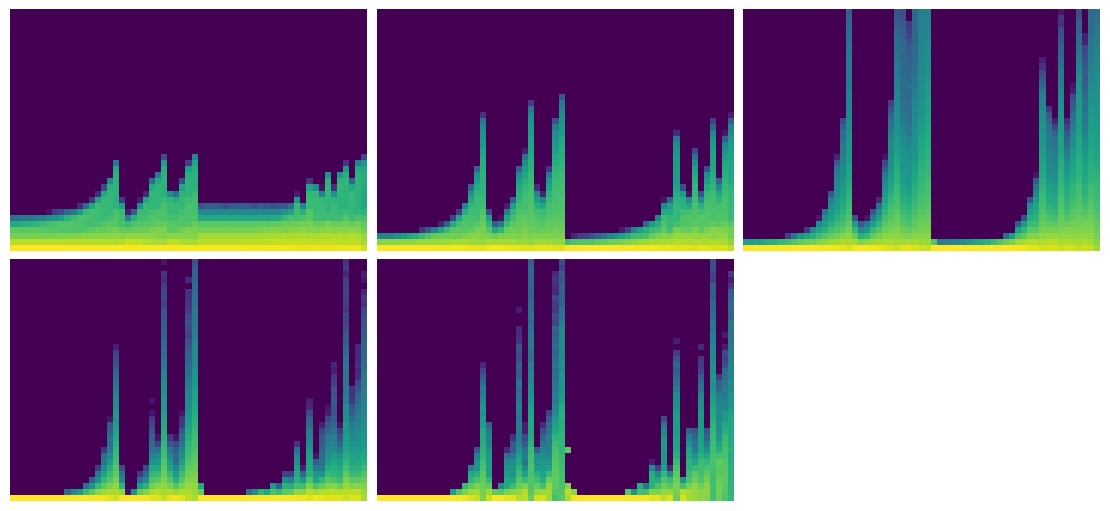

In [65]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flat, hc):
    show_image(get_hist(h), ax, origin='lower')

We are taking the histogram and making it into a color-coded single column plot.
Let's take a layer, number two.
We can take the very first column and so in the color
scheme that matplotlib picked, yellow is the most common, then light green is less common,
and then light blue, and then dark blue is zero.
The vast majority is zero and there's a few with slightly bigger numbers.
This is the same that we saw for index one layer here.
The average is pretty close to zero, the standard deviation is pretty small.
This is giving us more information, so as we train at this point here (first peak)
quite a few activations that are a lot larger, still the vast majority of them are very small.
But there's a few big ones so it's still got a bright yellow bar at the bottom.

```Python
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()
```
Notice that we've taken those histograms, stacked them all up into a single tensor 
and then we've taken their `log1p`.
log1p is just log of the number plus one.
That's because we've got zeros here and so just taking the log is going to 
let us see the full range more clearly.
Ideally we like to see here is that this whole thing should be more like a rectangle.
The maximum should not be changing very much.
There shouldn't be a thick yellow bar at the bottom, but instead it should be a nice 
even gradient, matching a normal distribution.
Each single column of pixels wants to have a normal distribution,
gradually decreasing the number of activations.
That's what we're aiming for.

Another easier way to read version of this is to take the ratio
of the very first smallest histogram bin to the rest of the bins, `h1[0]/h1.sum(0)`.
These are very *dead* at this point. 
Taking this ratio tells us what percentage have (near) zero or extremely small magnitudes.
These are absolute values so if we plot those you can see how bad this is.
For example the final layer from the very start nearly all of the activations are disabled.
If most of our model is close to 0 then most of it is doing no work.
So it may look like at the very end things were improving...
But as you can see from this chart that's not true.
Still the vast majority are inactive.

If early in training we see a rising crash Rising crash pattern, 
we should stop and restart training.
Such a model will probably never recover, as too many of the activations have gone off the rails.
So we want it to look kind of like this the whole time but
with less of this very thick yellow bar which is showing us most are inactive.

In [66]:
#|export
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0]/h1.sum(0)

so the graphs really look like very dead at this point.

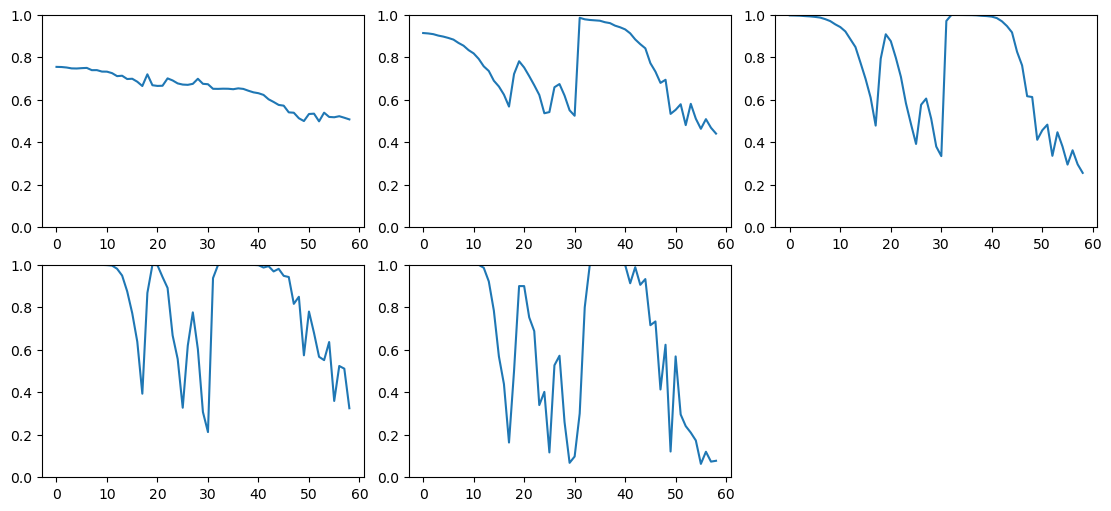

In [67]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flatten(), hc):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)

## ActivationStats

Now took the colorful Dimension `color_dim` and wrap it in a callback: `ActivationStats(HooksCallback)`
which is it's going to use `append_stats` which
appends the mains the standard deviations and the histograms.
Added the `color_dim` method, a `dead_chart` method and a `plot_stats` method.

In [68]:
#|export
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

To see them at work, if we want to get the activations on and all of the cons, 
then we train our model, created our `ActivationStats`, we've added that as an extra callback,
and then we can call `astats.color_dim(), astats.dead_chart()` and `astats.plot_stats()`.
to get each plot.

In [69]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.228,2.129,0,train
0.356,1.821,0,eval


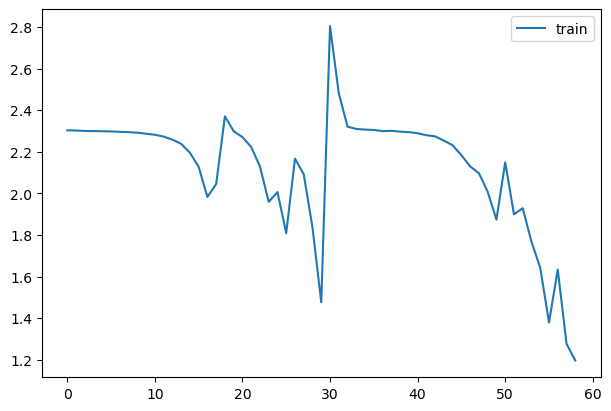

In [70]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats]);

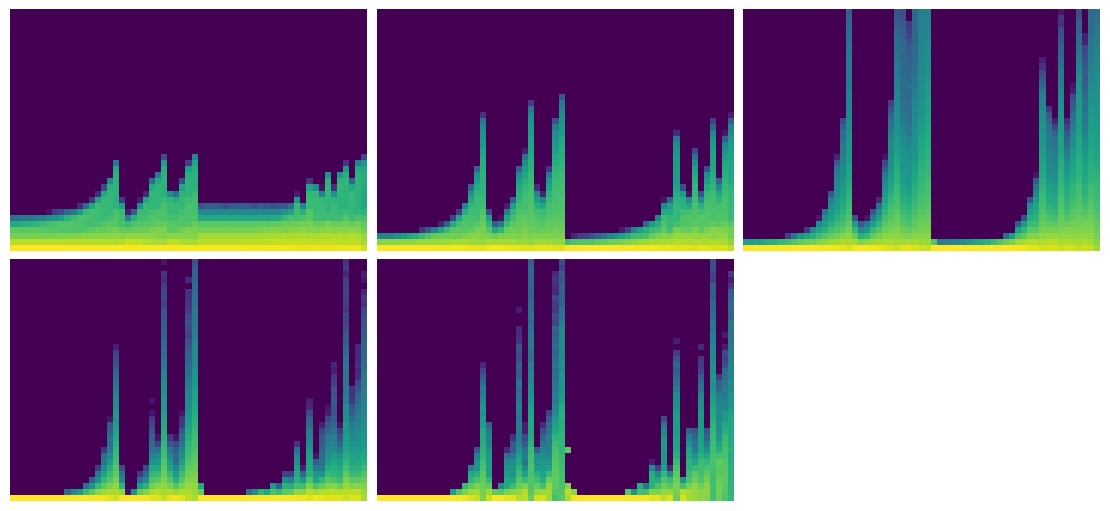

In [71]:
astats.color_dim()

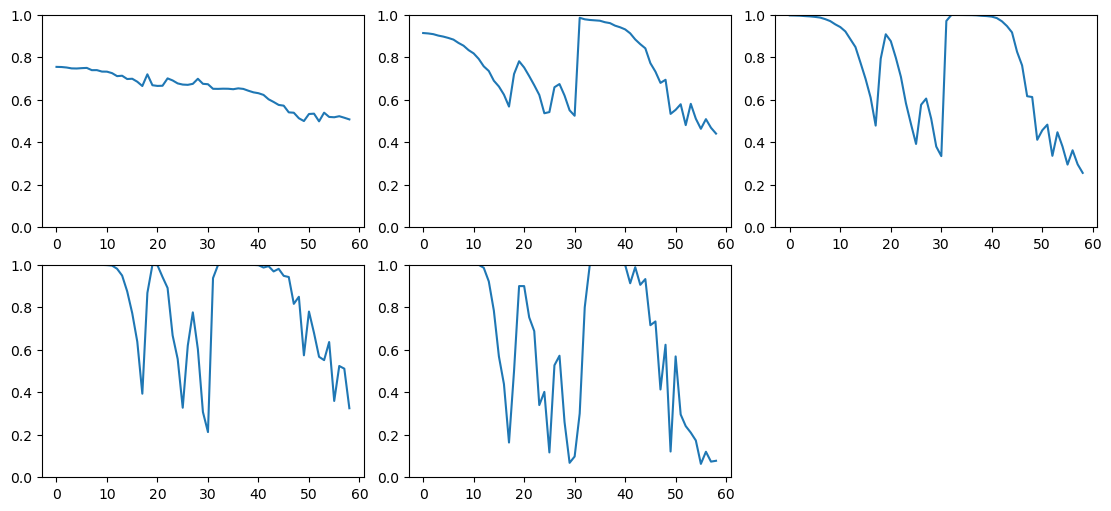

In [72]:
astats.dead_chart()

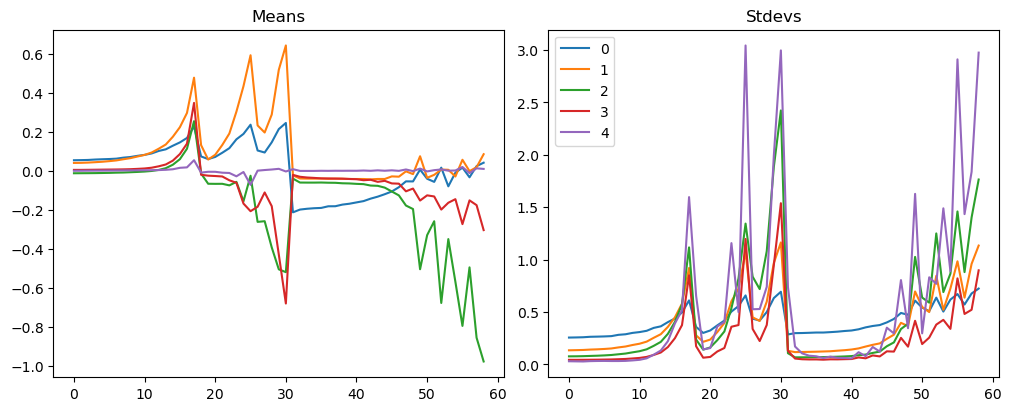

In [73]:
astats.plot_stats()

Now we can get all of these informative visualizations of what's going on inside our model. 
It's just adding one line of code and putting that in our callbacks.
Even for models we thought were training really well we can try using this and
might be surprised to discover that they're not okay... 

## Export -

In [76]:
import nbdev; nbdev.nbdev_export()